# Air Pollution Data Analysis in New York City

## Overview

Air pollution is a significant public health concern with a growing body of evidence linking it to various health problems, including respiratory infections, heart disease, and lung cancer. In urban areas like New York City, the concentration of pollutants can be particularly high due to factors such as dense traffic, industrial activities, and energy production. 

This notebook delves into historical air quality data obtained from the OpenWeatherMap API to analyze trends, identify days with critical pollution levels, and draw insights into the air quality of New York City. The analysis could help inform public health advisories and guide policies for environmental protection.

## Objectives

- **Data Acquisition**: Retrieve historical air pollution data from the OpenWeatherMap API.
- **Data Cleaning and Preparation**: Process the data to facilitate a smooth analysis workflow.
- **Exploratory Data Analysis (EDA)**: Conduct an initial exploration to understand the distributions and relationships within the data.
- **Trend Analysis**: Examine the data for long-term trends in various pollutants.
- **Peak Pollution Identification**: Identify specific timeframes with unusually high pollution levels.
- **Visualization**: Create compelling visual representations of the data to communicate findings effectively.
- **Predictive Analysis**: Attempt to forecast future pollution levels using time-series analysis techniques.

## Significance

Monitoring air pollution is crucial not only for the environment but also for the health and well-being of city residents. By analyzing historical data, we can identify patterns and potential causes of pollution peaks, assess the effectiveness of environmental regulations, and ultimately contribute to the development of strategies for improving air quality.

Understanding the nuances of air pollution also equips urban planners, policymakers, and the general public with the knowledge to make informed decisions, whether it's about regulating emissions, planning city infrastructure, or taking personal measures to reduce exposure to pollutants.

## Data Source

Data for this analysis is sourced from the OpenWeatherMap API, which provides comprehensive historical air pollution data. This reliable data source includes various pollutants such as PM2.5, PM10, CO, SO2, NO2, and O3, which are crucial for assessing air quality. The following code retrieves the geographical coordinates for New York City, necessary to fetch the corresponding pollution data.

## Data Acquisition

The first step in our analysis is to acquire historical air pollution data. This data provides the foundation for our subsequent cleaning, exploration, and analysis. We will access this data through the OpenWeatherMap API, which offers detailed historical records on various air pollutants.

In [80]:
import requests
import os
from dotenv import load_dotenv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First we need to set the api key so we can access the api
load_dotenv()
api_key = os.getenv("WEATHER_API_KEY")

In [81]:
#Fetch city coordinates from OpenWeatherMap API, to use to fetch air pollution data

def fetch_city_coordinates(api_key, city):
    url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=5&appid={api_key}"
    response = requests.get(url)
    return response.json()

city_coordinates = fetch_city_coordinates(api_key, city="New York City")
lat = city_coordinates[0]['lat']
lon = city_coordinates[0]['lon']

#Using city coordinates as params, fetch historical air pollution data of NYC

def fetch_air_pollution_data(api_key, lat, lon, start, end):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={api_key}"
    response = requests.get(url)
    return response.json()

air_pollution_data = fetch_air_pollution_data(api_key, lat, lon, start=1606488670, end=1606747870)

## Data Cleaning and Preparation

Once we've acquired the data, it's crucial to clean and prepare it for analysis. This process includes renaming column names for clarity, converting data types, and structuring the data in a way that facilitates easy analysis—paving the way for a seamless exploration.

In [82]:
#Process data and convert to Pandas DataFrame
air_pollution_data_list = air_pollution_data['list']

df = pd.DataFrame(air_pollution_data_list)

# Expanding the 'main' and 'components' dictionaries into separate columns
df_main = df['main'].apply(pd.Series)
df_components = df['components'].apply(pd.Series)

# Convert UNIX timestamps to datetime
df['dt'] = pd.to_datetime(df['dt'], unit='s')

# Concatenating all data into one DataFrame
df = pd.concat([df.drop(['main', 'components'], axis=1), df_main, df_components], axis=1)
df.head()

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-27 15:00:00,4,1134.87,135.90,29.13,2.66,6.32,33.99,50.53,4.94
1,2020-11-27 16:00:00,2,620.84,51.41,31.53,9.21,14.42,16.51,24.08,3.17
2,2020-11-27 17:00:00,2,567.44,39.79,39.07,12.88,17.17,15.99,22.75,3.36
3,2020-11-27 18:00:00,2,547.41,33.98,46.61,13.05,18.84,15.55,22.25,3.61
4,2020-11-27 19:00:00,2,527.38,28.16,48.67,11.80,15.26,13.43,19.61,3.58


In [83]:
#Let's also rename column names to be clearer 

new_column_names = ['DateTime', 'Air Quality Index', 'CO Concentration', 'NO Concentration', 'NO2 Concentration',
                    'O3 Concentration', 'SO2 Concentration', 'PM2_5 Concentration', 'PM10 Concentration', 'NH3 Concentration']

df.columns = new_column_names
df.head()

,DateTime,Air Quality Index,CO Concentration,NO Concentration,NO2 Concentration,O3 Concentration,SO2 Concentration,PM2_5 Concentration,PM10 Concentration,NH3 Concentration
0,2020-11-27 15:00:00,4,1134.87,135.90,29.13,2.66,6.32,33.99,50.53,4.94
1,2020-11-27 16:00:00,2,620.84,51.41,31.53,9.21,14.42,16.51,24.08,3.17
2,2020-11-27 17:00:00,2,567.44,39.79,39.07,12.88,17.17,15.99,22.75,3.36
3,2020-11-27 18:00:00,2,547.41,33.98,46.61,13.05,18.84,15.55,22.25,3.61
4,2020-11-27 19:00:00,2,527.38,28.16,48.67,11.80,15.26,13.43,19.61,3.58


## Exploratory Data Analysis (EDA)

With our data cleaned and prepared, we move onto exploratory data analysis (EDA). EDA is an open-ended process where we calculate statistics and create visualizations with the aim of uncovering patterns, spotting anomalies, checking assumptions, or testing hypotheses about our data.

In [84]:
# Let's use the describe method to display statistical summaries 

df.describe()

,DateTime,Air Quality Index,CO Concentration,NO Concentration,NO2 Concentration,O3 Concentration,SO2 Concentration,PM2_5 Concentration,PM10 Concentration,NH3 Concentration
count,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2020-11-29 02:30:00,2.236111,558.118611,28.412222,45.904167,10.448056,7.569306,15.486389,22.172500,3.044583
min,2020-11-27 15:00:00,1.000000,273.710000,0.050000,13.540000,0.000000,2.330000,2.930000,4.650000,0.720000
25%,2020-11-28 08:45:00,2.000000,423.910000,6.830000,36.670000,0.017500,4.380000,9.175000,14.082500,1.720000
50%,2020-11-29 02:30:00,2.000000,540.730000,27.380000,44.210000,1.810000,6.230000,13.130000,19.500000,3.170000
75%,2020-11-29 20:15:00,3.000000,684.262500,38.447500,52.780000,13.945000,9.090000,20.222500,28.160000,4.060000
max,2020-11-30 14:00:00,4.000000,1134.870000,135.900000,80.200000,61.510000,20.740000,33.990000,50.530000,6.020000
std,NaN,0.985716,179.957951,26.980048,15.181001,16.045039,4.422800,8.659422,11.417194,1.427934


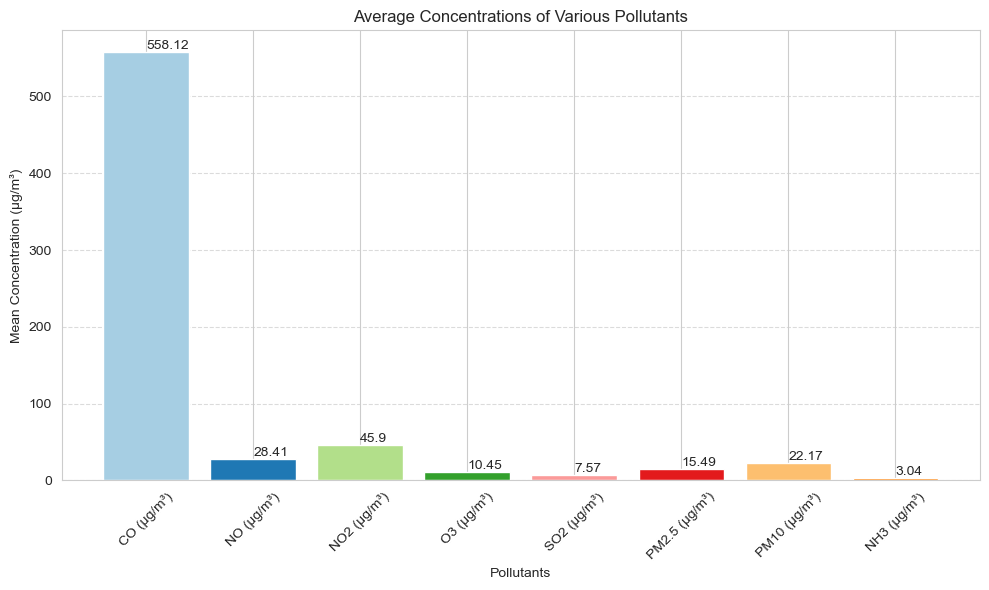

In [85]:
#Let's create a bar chart to illustrate mean levels

# Create a dictionary with the mean values
mean_values = df.drop('DateTime', axis=1).describe().loc['mean'].round(2)
pollutant_means = mean_values.to_dict()

pollutant_means = {'CO (µg/m³)': pollutant_means['CO Concentration'],
                   'NO (µg/m³)': pollutant_means['NO Concentration'],
                   'NO2 (µg/m³)': pollutant_means['NO2 Concentration'],
                   'O3 (µg/m³)': pollutant_means['O3 Concentration'],
                   'SO2 (µg/m³)': pollutant_means['SO2 Concentration'],
                   'PM2.5 (µg/m³)': pollutant_means['PM2_5 Concentration'],
                   'PM10 (µg/m³)': pollutant_means['PM10 Concentration'],
                   'NH3 (µg/m³)': pollutant_means['NH3 Concentration']}

# Convert the dictionary to a DataFrame for easier plotting
df_means = pd.DataFrame(list(pollutant_means.items()), columns=['Pollutant', 'Mean Concentration'])

plt.figure(figsize=(10, 6))
bars = plt.bar(df_means['Pollutant'], df_means['Mean Concentration'], color=plt.cm.Paired(range(len(df_means))))

plt.title('Average Concentrations of Various Pollutants')
plt.xlabel('Pollutants')
plt.ylabel('Mean Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.show()

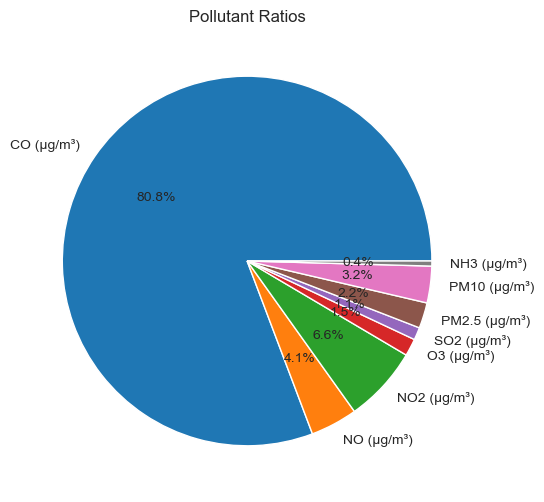

In [55]:
# We can also create a pie chart to better illustrate pollutant ratios

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df_means['Mean Concentration'], labels=df_means['Pollutant'], autopct='%1.1f%%')
plt.title('Pollutant Ratios')
plt.show()

/Users/danieltiourine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danieltiourine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danieltiourine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danieltiourine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

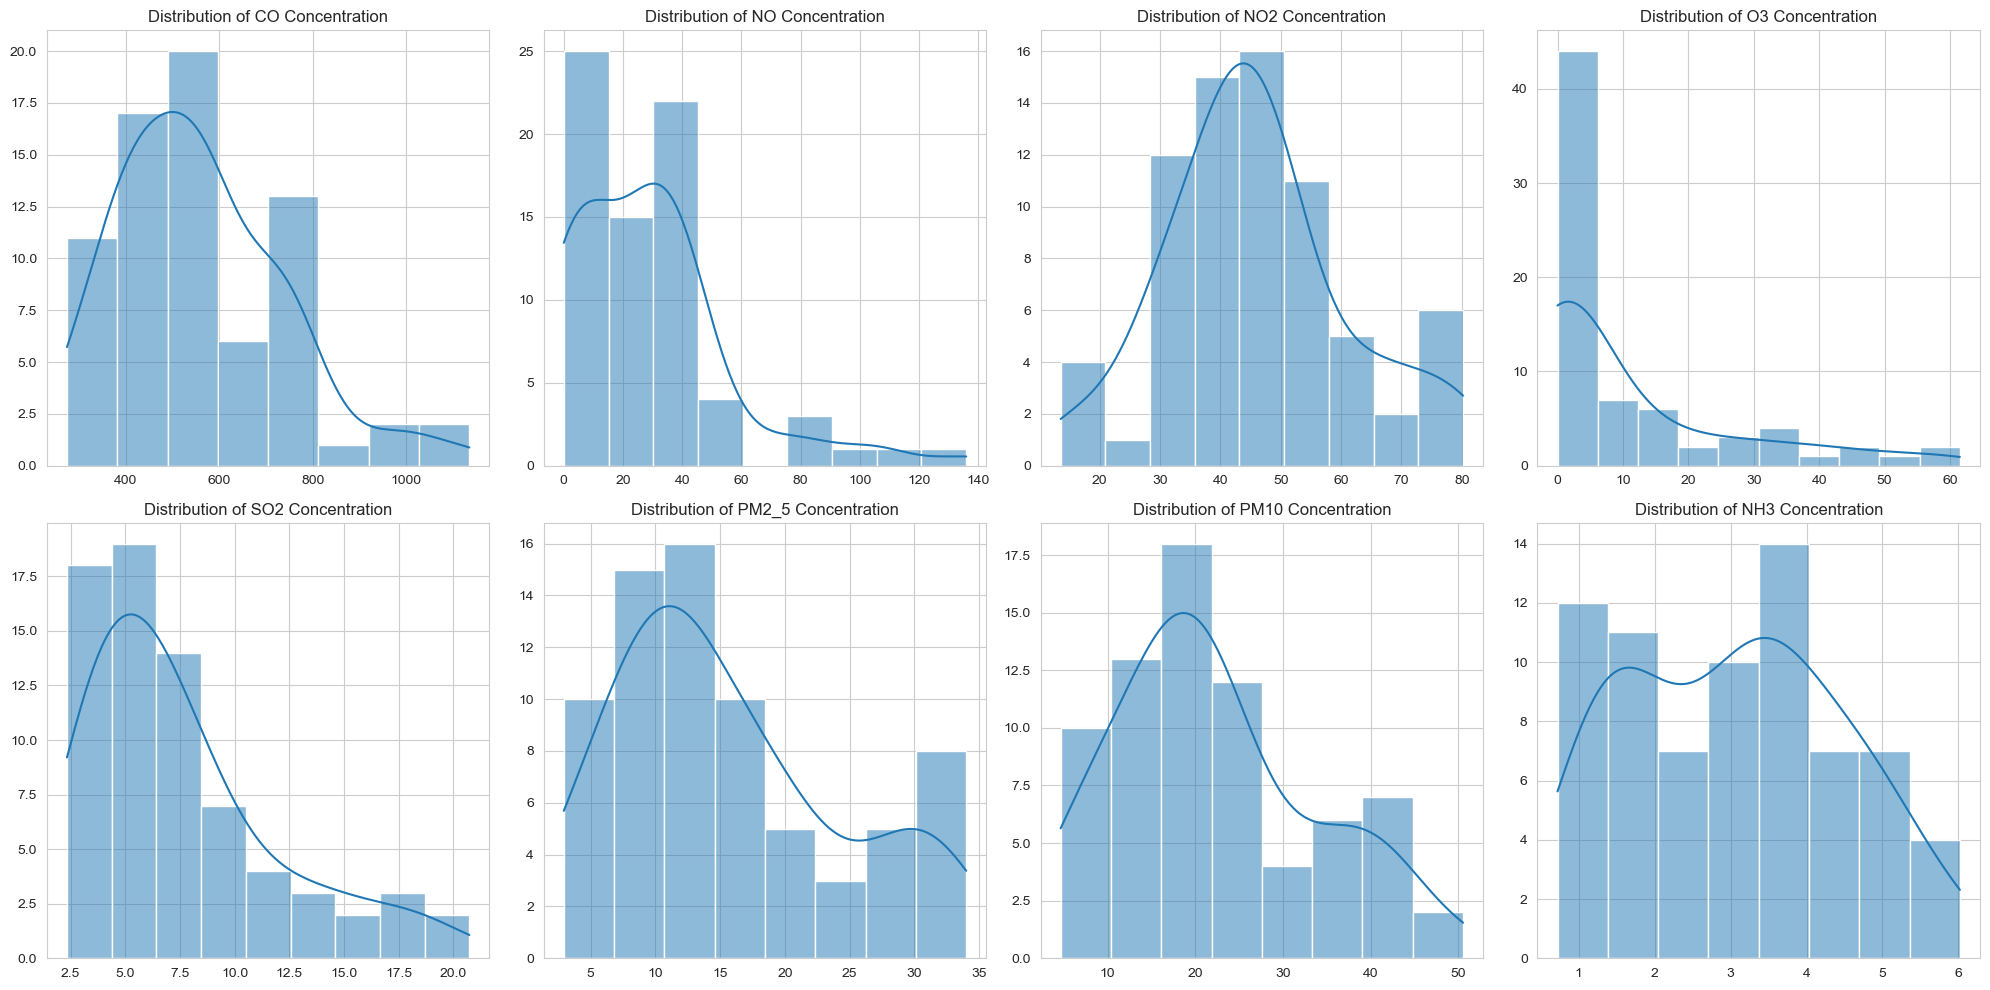

In [87]:
# Now let's plot the distributions of the different pollutant concentrations

pollutants = ['CO Concentration', 'NO Concentration', 
              'NO2 Concentration', 'O3 Concentration', 'SO2 Concentration', 
              'PM2_5 Concentration', 'PM10 Concentration', 'NH3 Concentration']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the pollutants and create a histogram for each
for i, pollutant in enumerate(pollutants):
    sns.histplot(df[pollutant], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {pollutant}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

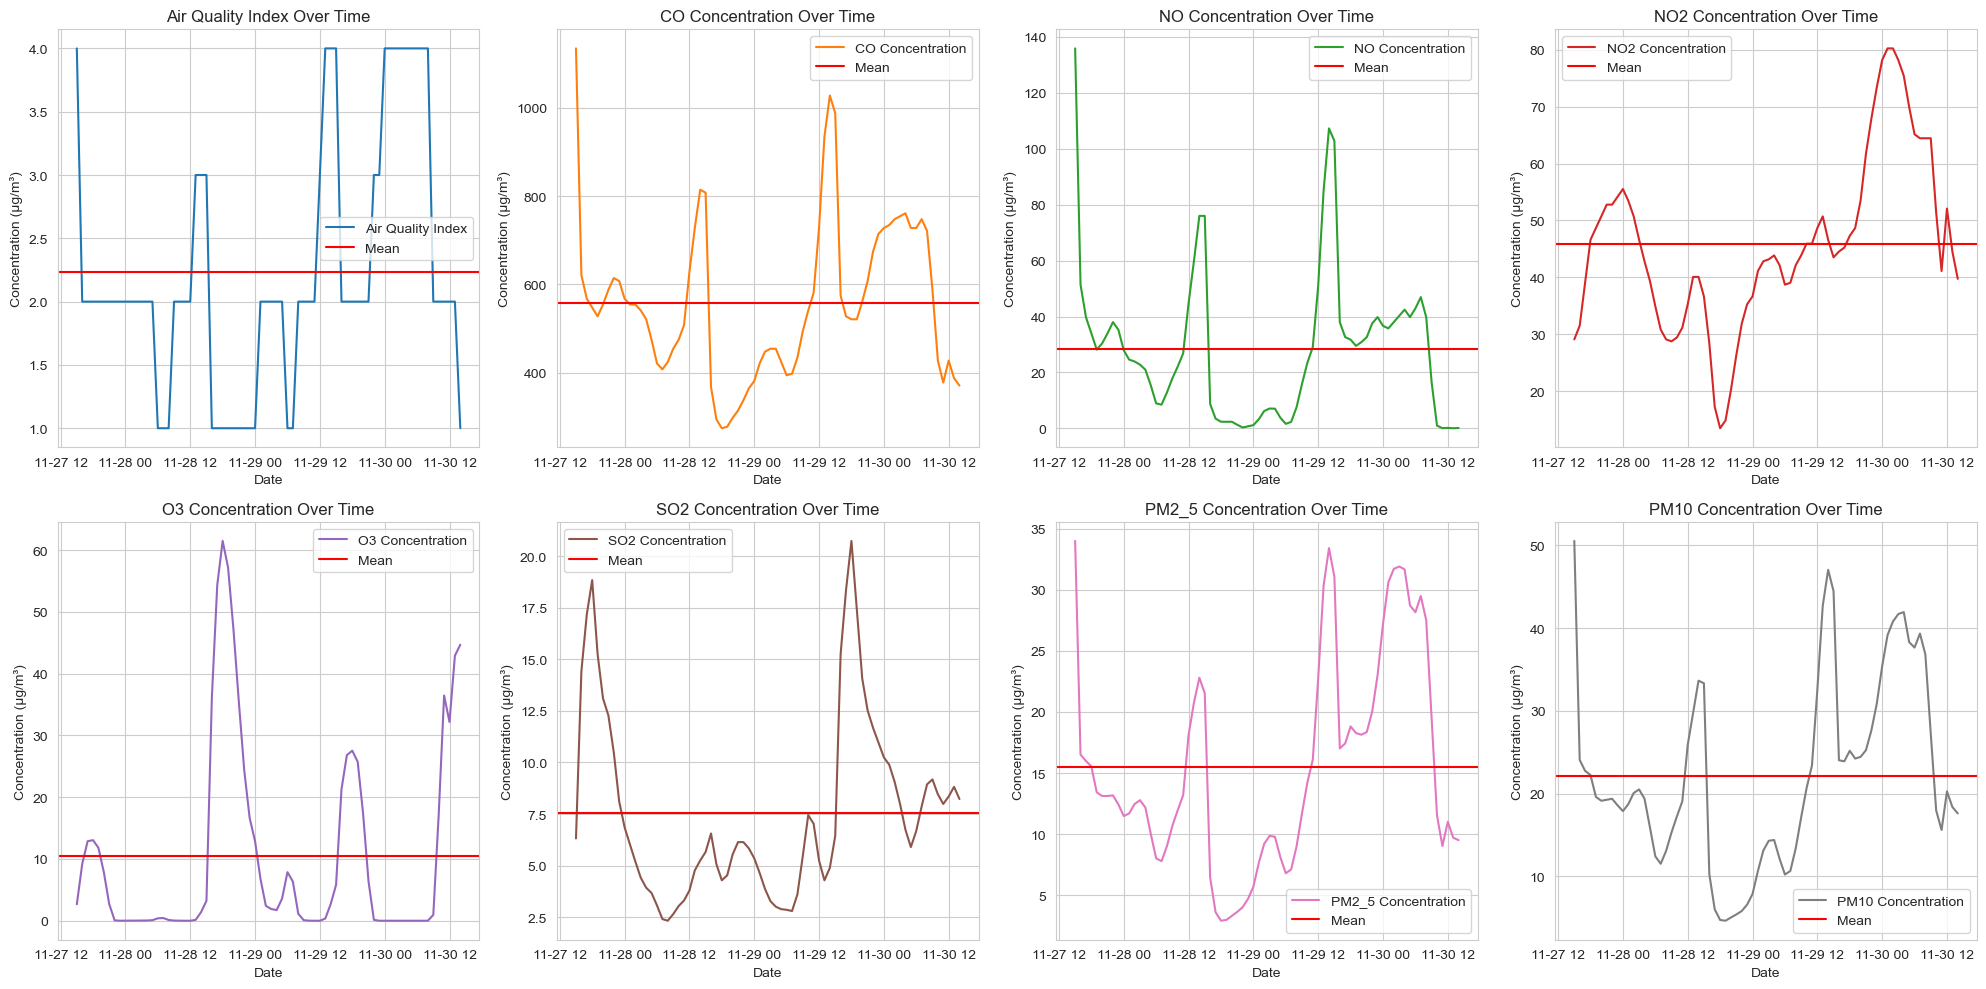

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of pollutant names and their corresponding DataFrame columns
pollutants = {
    'Air Quality Index': 'Air Quality Index',
    'CO Concentration': 'CO Concentration',
    'NO Concentration': 'NO Concentration',
    'NO2 Concentration': 'NO2 Concentration',
    'O3 Concentration': 'O3 Concentration',
    'SO2 Concentration': 'SO2 Concentration',
    'PM2_5 Concentration': 'PM2_5 Concentration',
    'PM10 Concentration': 'PM10 Concentration'
}

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array of axes

# Loop through each pollutant and create a time series plot
for i, (name, column) in enumerate(pollutants.items()):
    axes[i].plot(df['DateTime'], df[column], label=f'{name}', color=sns.color_palette("tab10")[i])
    axes[i].axhline(y=df[column].mean(), color='red', linestyle='-', label='Mean')
    axes[i].set_title(f'{name} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Concentration (µg/m³)')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

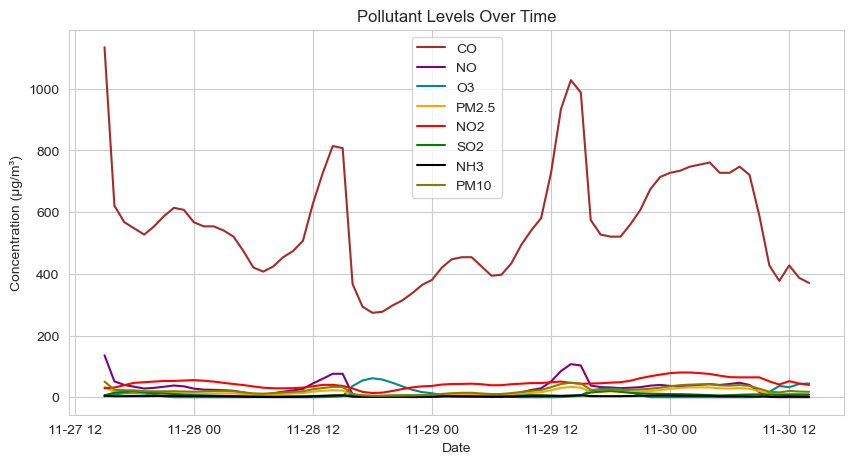

In [71]:
# Graph levels of other pollutants

plt.figure(figsize=(10, 5))

plt.plot(df.index, df['CO Concentration'], linestyle='-', color='brown', label='CO')
plt.plot(df.index, df['NO Concentration'], linestyle='-', color='purple', label='NO')
plt.plot(df.index, df['O3 Concentration'], linestyle='-', color='darkcyan', label='O3')
plt.plot(df.index, df['PM2_5 Concentration'], linestyle='-', color='orange', label='PM2.5')
plt.plot(df.index, df['NO2 Concentration'], linestyle='-', color='red', label='NO2')
plt.plot(df.index, df['SO2 Concentration'], linestyle='-', color='green', label='SO2')
plt.plot(df.index, df['NH3 Concentration'], linestyle='-', color='black', label='NH3')
plt.plot(df.index, df['PM10 Concentration'], linestyle='-', color='olive', label='PM10')

plt.title('Pollutant Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')

plt.legend()

plt.grid(True)

plt.show()

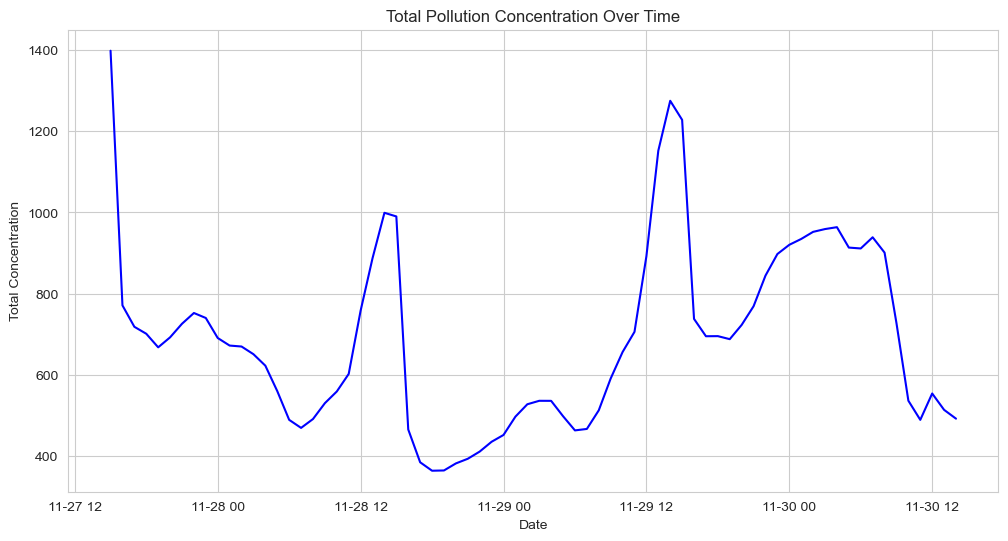

In [66]:
# Let's also look at the levels of total concentration of all the pollutants combined

concentration_sum = df[['NO Concentration', 'CO Concentration', 'O3 Concentration', 'PM2_5 Concentration', 
                        'NO2 Concentration', 'SO2 Concentration', 'NH3 Concentration', 'PM10 Concentration']].sum(axis=1)

df['total_concentration'] = concentration_sum

df.set_index('DateTime', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_concentration'], linestyle='-', color='blue')
plt.title('Total Pollution Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('Total Concentration')
plt.grid(True)
plt.show()

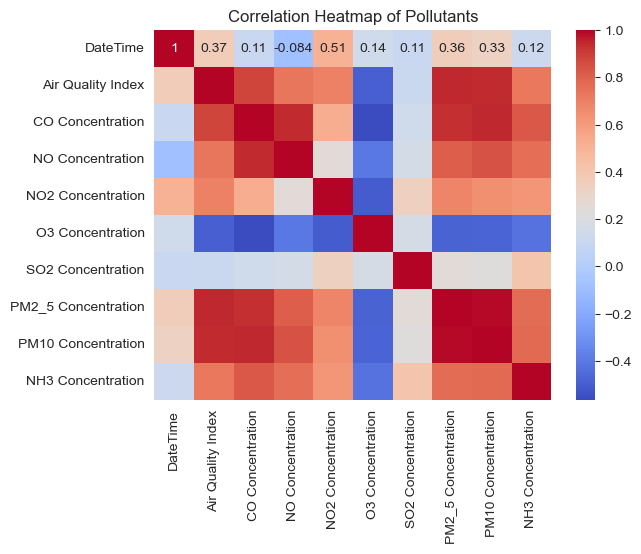

In [91]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Pollutants')
plt.show()

## Trend Analysis

Building on our exploratory data analysis, we now focus on identifying long-term trends in the data. This involves using statistical methods and time-series analysis techniques to detect whether pollutants' levels are increasing, decreasing, or remaining stable over time.

In [89]:
# Finding smallest and largest total concentrations
#smallest_five = concentration_sum.nsmallest(5)
#largest_five = concentration_sum.nlargest(5)

# Display corresponding dates and concentration totals
#corresponding_smallest_dates = df.loc[smallest_five.index, ['dt', 'total_concentration']]
#corresponding_largest_dates = df.loc[largest_five.index, ['dt', 'total_concentration']]

# Display the results
#print("Dates with the smallest total concentrations:")
#print(corresponding_smallest_dates)
#print("\nDates with the largest total concentrations:")
#print(corresponding_largest_dates)